# GRADIENT BOOSTING REGRESSOR
Columnas usadas: carat, cut_num, color_num, clarity_num, x,y,z, depth, table
Sin escalar

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [55]:
diamonds_train = pd.read_csv('data/diamonds_train.csv')
diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [56]:
diamonds_predict = pd.read_csv('data/diamonds_test.csv')

## GETTING RID OF 0 IN xyz

### TRAIN

In [57]:
diamonds_train = diamonds_train[(diamonds_train['x'] != 0) & (diamonds_train['y'] != 0) & (diamonds_train['z'] != 0)]
diamonds_train.shape

(40439, 10)

### TEST

Celda no ejecutada porque al eliminar rows en el csv de test, da fallo la submission

diamonds_predict = diamonds_predict[(diamonds_predict['x'] != 0) & (diamonds_predict['y'] != 0) & (diamonds_predict['z'] != 0)]
diamonds_predict.info()

## GET RID OF OUTLIERS

Tried with 75-25, not a good idea shape=(6465, 10), we gonna try with some less outliers

In [58]:
 len(diamonds_train[diamonds_train["table"]>70])

6

In [59]:
# Hay un diamante con un depth de 79
diamonds_train = diamonds_train[(diamonds_train["depth"]<71) & (diamonds_train["depth"]>54)]

# Hay 3 mayores de 75 y dos menores de 45
diamonds_train = diamonds_train[(diamonds_train["table"]<70) & (diamonds_train["table"]>52)]

diamonds_train = diamonds_train[(diamonds_train["x"]<10)] 
#solo dropeamos las que sean x<10 porque coincide con 'y' en sus dos únicos valores por encima de 10 y no dropeamos nada de z porque hay bastantes valores en torno a 6

In [60]:
diamonds_train.shape

(40345, 10)

# ENCODING CATEGORIES

## TRAIN

In [61]:
cut_num = {'Ideal': 5, 'Premium': 4, 'Very Good': 3, 'Good': 2, 'Fair': 1}
diamonds_train['cut_num'] = diamonds_train['cut'].replace(cut_num)

In [62]:
color_num = {'D': 7, 'E': 6, 'F': 5, 'G': 4, 'H': 3, 'I': 2, 'J': 1}
diamonds_train['color_num'] = diamonds_train['color'].replace(color_num)

In [63]:
clarity_num = {'IF': 8, 'VVS1': 7, 'VVS2': 6, 'VS1': 5, 'VS2': 4, 'SI1': 3, 'SI2': 2, 'I1': 1}
diamonds_train['clarity_num'] = diamonds_train['clarity'].replace(clarity_num)

## TEST CSV (nuestro diamonds_predict)

In [64]:
diamonds_predict['cut_num'] = diamonds_predict['cut'].replace(cut_num)

diamonds_predict['color_num'] = diamonds_predict['color'].replace(color_num)

diamonds_predict['clarity_num'] = diamonds_predict['clarity'].replace(clarity_num)

# FEATURE ENGINERING

## VOlume


In [65]:
diamonds_train['volume'] = diamonds_train.x * diamonds_train.y * diamonds_train.z
diamonds_predict['volume'] = diamonds_predict.x * diamonds_predict.y * diamonds_predict.z

## l/w ratio

In [66]:
diamonds_train['l/w ratio'] = diamonds_train.x/diamonds_train.y
diamonds_predict['l/w ratio'] = diamonds_predict.x/diamonds_predict.y

## Depth ratio

In [67]:
diamonds_train['depth ratio'] = diamonds_train.z/diamonds_train.y
diamonds_predict['depth ratio'] = diamonds_predict.z/diamonds_predict.y

## HEATMAP

Depth & cut no están muy relacionados con el precio

<AxesSubplot:>

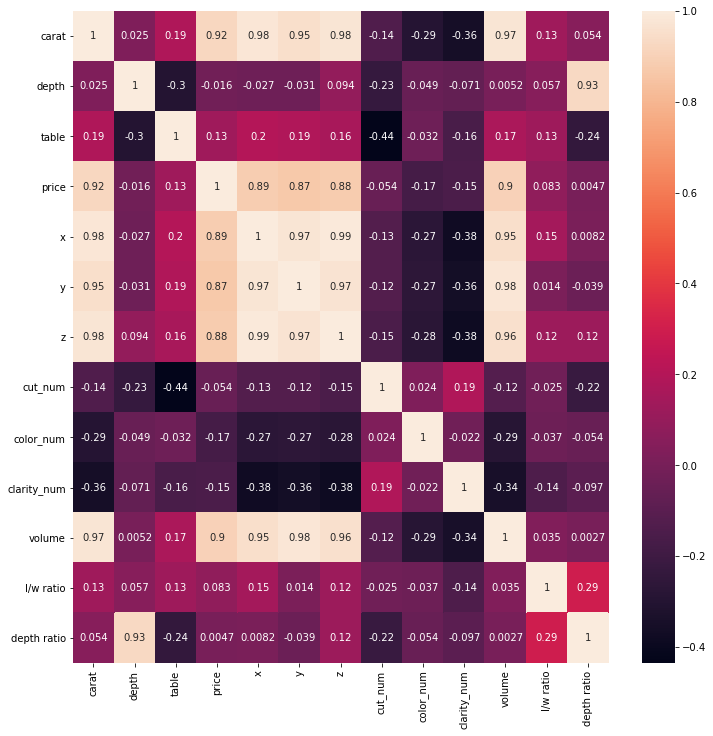

In [68]:
plt.figure(figsize=(12,12))
corr = diamonds_train.corr()
sns.heatmap(data=corr, annot=True, cbar=True)

# ESCALAR

In [69]:
#cat_features = ['cut', 'color', 'clarity']
features = ['carat', 'l/w ratio', 'volume', 'cut_num', 'color_num', 'clarity_num', 'depth ratio']
#predict_feat = ['id','carat', 'table', 'depth', 'x', 'y', 'z', 'cut_num', 'color_num', 'clarity_num']
target = 'price'

### TRAIN

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
scaler = StandardScaler()

In [72]:
X = scaler.fit_transform(diamonds_train[features])
y = diamonds_train[target]

### TEST CSV (PREDICT)

In [73]:
X_pred = scaler.fit_transform(diamonds_predict[features])

# TRAIN-TEST-SPLIT

In [74]:
from sklearn.model_selection import train_test_split 

In [75]:
#X = diamonds_train[features]
#y = diamonds_train[target]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### TEST

# MODELS

In [77]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

## 1. RANDOM FOREST

In [50]:
rfr_model = RandomForestRegressor()

In [51]:
rfr_model.fit(X_train, y_train)

RandomForestRegressor()

In [52]:
y_pred = rfr_model.predict(X_test)

In [53]:
cv_score = cross_val_score(estimator=rfr_model, X=X_train, y=y_train, cv=5,verbose = 1)
print('Cross validation score : %.4f' % rfr_model.score(X_test, y_test))
print(cv_score)
mae = mean_absolute_error(y_test,y_pred)
print("mae: %f" %(mae))
r2 = rfr_model.score(X_test,y_pred)
print("R2: %f" %(r2))
mse = mean_squared_error(y_test,y_pred)
print("mse: %f" %(mse))
rmse = (mean_squared_error(y_test,y_pred))**0.5
print("rmse: %f" %(rmse))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.1s finished


Cross validation score : 0.9804
[0.98147101 0.9794925  0.97957579 0.9805413  0.97941591]
mae: 285.283409
R2: 1.000000
mse: 312886.610782
rmse: 559.362683


In [ ]:
## Resultado con menor borrado de outliers
""" 

"""

In [ ]:
#crossval_score = cross_val_score(rfr_model, X_train, y_train, cv=10)
#print(cross_val_score)

## 2. DECISION TREE

In [44]:
dtr_model = DecisionTreeRegressor(random_state = 0) #rstate=0 porque los resultados son mejores que sin poner nada o poniendo 1
dtr_model.fit(X_train, y_train)
y_pred = dtr_model.predict(X_test)

In [45]:
cv_score = cross_val_score(estimator=dtr_model, X=X_train, y=y_train, cv=10,verbose = 1)
print('Cross validation score : %.4f' % dtr_model.score(X_test, y_test))
print(cv_score)
mae = mean_absolute_error(y_test,y_pred)
print("mae: %f" %(mae))
r2 = dtr_model.score(X_test,y_pred)
print("R2: %f" %(r2))
mse = mean_squared_error(y_test,y_pred)
print("mse: %f" %(mse))
rmse = (mean_squared_error(y_test,y_pred))**0.5
print("rmse: %f" %(rmse))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation score : 0.96
[0.96450578 0.96726044 0.9611957  0.96555221 0.96653727 0.96634583
 0.96426999 0.95590837 0.96285539 0.96450497]
mae: 366.196292
R2: 1.000000
mse: 574153.135025
rmse: 757.728932


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished


In [ ]:
"""
Cross validation score : 0.96
[0.96471869 0.96286045 0.96237324 0.96244763 0.96538262]
mae: 369.804442
R2: 1.000000
mse: 570145.458766
rmse: 755.079770
"""

mae = mean_absolute_error(y_test,y_pred)
print("mae: %f" %(mae))
r2 = rfr_model.score(X_test,y_test)
print("R2: %f" %(r2))
mse = mean_squared_error(y_test,y_pred)
print("mse: %f" %(mse))
rmse = (mean_squared_error(y_test,y_pred))**0.5
print("rmse: %f" %(rmse))

RESULTADOS SIN CAMBIAR RANDOM STATE:, con random state = 0, mejora
mae: 372.840853
R2: 0.980116
mse: 579384.121723
rmse: 761.172859

## 3. GRADIENT BOOSTING

In [24]:
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls',verbose = 1)
#max_depth 1, mal, 2, mal, 4 ok (553 rmse), 8 ok (542)

In [25]:
gbr_model.fit(X_train , y_train)
y_pred = gbr_model.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1    12936947.4812            4.81s
         2    10557284.3313            5.55s
         3     8624283.3733            5.32s
         4     7055767.8721            4.93s
         5     5783561.6739            4.97s
         6     4749538.7543            4.74s
         7     3911150.9818            4.55s
         8     3227692.8208            4.40s
         9     2673475.9653            4.29s
        10     2222692.9300            4.21s
        20      490931.4204            3.55s
        30      246305.2666            3.08s
        40      195531.9515            2.62s
        50      174906.7465            2.18s
        60      163318.1865            1.92s
        70      152130.9644            1.49s
        80      142117.8535            1.02s
        90      131748.7006            0.50s
       100      124896.5174            0.00s


In [49]:
cv_score = cross_val_score(estimator=gbr_model, X=X_train, y=y_train, cv=5,verbose = 1)
print('Cross validation score : %.4f' % gbr_model.score(X_test, y_test))
print(cv_score)
mae = mean_absolute_error(y_test, y_pred)
print("mae: %f" %(mae))
r2 = gbr_model.score(X_test,y_pred)
print("R2: %f" %(r2))
mse = mean_squared_error(y_test, y_pred)
print("mse: %f" %(mse))
rmse = (mean_squared_error(y_test, y_pred))**0.5
print("rmse: %f" %(rmse))

      Iter       Train Loss   Remaining Time 
         1    12874529.6341            5.04s
         2    10504337.0211            4.56s
         3     8582170.0018            4.11s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


         4     7022206.2891            3.95s
         5     5755803.4239            3.96s
         6     4727662.6893            4.20s
         7     3893025.2120            4.15s
         8     3214353.2650            3.97s
         9     2661800.3875            3.84s
        10     2212084.4484            3.89s
        20      485351.5014            3.21s
        30      238372.6274            2.70s
        40      185545.7902            2.27s
        50      164201.1797            1.86s
        60      150144.3756            1.47s
        70      140345.5667            1.09s
        80      129056.6853            0.73s
        90      123359.1384            0.36s
       100      115750.6514            0.00s
      Iter       Train Loss   Remaining Time 
         1    12957222.5324            3.49s
         2    10573689.2546            3.37s
         3     8639823.0221            3.36s
         4     7067420.9307            3.32s
         5     5794146.5889            3.30s
         

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.0s finished


In [ ]:
"""
Cross validation score : 0.9815
[0.98252068 0.98130918 0.98244676 0.97857692 0.98098148]
mae: 268.266150
R2: 1.000000
mse: 287796.842194
rmse: 536.467000
"""

## LIGHT GBM

In [78]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [79]:
hgbr_model = HistGradientBoostingRegressor()

In [80]:
hgbr_model.fit(X_train, y_train)
y_pred = hgbr_model.predict(X_test)

In [81]:
cv_score = cross_val_score(estimator=hgbr_model, X=X_train, y=y_train, cv=5,verbose = 1)
print('Cross validation score : %.4f' % hgbr_model.score(X_test, y_test))
print(cv_score)
mae = mean_absolute_error(y_test, y_pred)
print("mae: %f" %(mae))
r2 = hgbr_model.score(X_test,y_pred)
print("R2: %.4f" %(r2))
mse = mean_squared_error(y_test, y_pred)
print("mse: %f" %(mse))
rmse = (mean_squared_error(y_test, y_pred))**0.5
print("rmse: %f" %(rmse))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation score : 0.9826
[0.98385577 0.98257583 0.98277817 0.98077948 0.98188145]
mae: 272.296533
R2: 1.0000
mse: 277673.968335
rmse: 526.947785


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


In [ ]:
Cross validation score : 0.9822
[0.98270454 0.98172722 0.98241903 0.97935203 0.9816655 ]
mae: 280.066804
R2: 1.0000
mse: 284251.192566
rmse: 533.152129

# ERROR METRICS

### MAE

In [ ]:
mae = mean_absolute_error(Y_test,y_pred)
print("mae: %f" %(mae))

### RMSE

In [ ]:
rmse = (mean_squared_error(Y_test,y_pred))**0.5
print("rmse: %f" %(rmse))

### R2

In [ ]:
Rsquare=regressor.score(X_test,Y_test)
print("Rsquare: %f" %(Rsquare))

## PREDICTION

In [82]:
X_predict = X_pred # diamonds_predict[features] if not scaled
predictions = hgbr_model.predict(X_predict)
diamonds_id = diamonds_predict['id']

# GENERAR DF

In [83]:
submission = pd.DataFrame({'id': diamonds_id, 'price': predictions})

In [84]:
submission.shape

(13485, 2)

In [85]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13485 entries, 0 to 13484
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      13485 non-null  int64  
 1   price   13485 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 210.8 KB


In [86]:
submission.to_csv('submission.csv', index=False)